In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import ipdb
import cv2
import os
import pickle
import nltk
import time
import pylab as plot
## set seeds
from utils_picking import my_read_old, intersect, round_percent, get_indices_diff_list_suffix, vqa_score_list
import random
random.seed(1234)

In [2]:
### make changes here

TEST_SPLIT = 'val2014'
DIST_NORM = 1

results_edit_val_old = '/BS/vedika2/work/snmn/exp_vqa/eval_outputs_vqa_v2/vqa_v2_scratch_train/old_style_vqa_v2_edited_val2014_vqa_v2_scratch_train_15000_results.pickle'
results_val_old = '/BS/vedika2/work/snmn/exp_vqa/eval_outputs_vqa_v2/vqa_v2_scratch_train/old_style_vqa_v2_val2014_vqa_v2_scratch_train_15000_results.pickle'

## standard_vocab file_model_specific
standard_vocab_ans_file = '/BS/vedika2/work/snmn/exp_vqa/data/answers_vqa.txt'
with open(standard_vocab_ans_file) as f:
    ans_vocab_list = f.read().splitlines()


In [3]:
coco_json = '/BS/vedika2/work/snmn/coco_cat_ids.json'
with open(coco_json) as file:
    coco_f = json.load(file)
coco_dict = {}
for idx, details in enumerate(coco_f):
    # print(details)
    coco_dict[details['id']] = details['name']
coco_dict_inv = {}
for idx, details in enumerate(coco_f):
    # print(details)
    coco_dict_inv[details['name']] = details['id']

ques_type_file = '/BS/vedika3/work/VQA_helper_tools_official/QuestionTypes/mscoco_question_types.txt'
with open(ques_type_file) as f:
    ques_type_off = f.read().splitlines()
    
ans_type_off = ['yes/no', 'number', 'other']

img_dir = '/BS/databases10/VQA_v2/Images/' + TEST_SPLIT + '/'
edit_img_dir = '/BS/vedika2/work/thesis/final_edited_VQA_v2/Images/' + TEST_SPLIT + '/'
img_prefix_name = 'COCO_' + TEST_SPLIT + '_'

#### questions keys: 'image_id', 'question', 'question_id'
standard_questions_val_json = '/BS/databases10/VQA_v2/Questions/v2_OpenEnded_mscoco_' + TEST_SPLIT + '_questions.json'
standard_questions_edit_val_json = '/BS/vedika2/work/thesis/final_edited_VQA_v2/Questions/v2_OpenEnded_mscoco_' + TEST_SPLIT + '_questions.json'

## ann keys: 'image_id', 'question_id', 'answers' , 'multiple_choice_answer'(the most frequent answer), 'question_type', 'answer_type'
standard_annotations_val_json = '/BS/databases10/VQA_v2/Annotations/v2_mscoco_' + TEST_SPLIT + '_annotations.json'
standard_annotations_edit_val_json = '/BS/vedika2/work/thesis/final_edited_VQA_v2/Annotations/v2_mscoco_' + TEST_SPLIT + '_annotations.json'

qid_val, pred_ans_val , ss_vc_val, img_ids_val, ques_val, all_ans_val, ques_type_val, ans_type_val, gt_ans_used_val = \
    my_read_old(results_val_old, standard_questions_val_json, standard_annotations_val_json)
qid_edit_val, pred_ans_edit_val , ss_vc_edit_val, img_ids_edit_val, ques_edit_val, all_ans_edit_val, ques_type_edit_val, ans_type_edit_val, gt_ans_used_edit_val = \
    my_read_old(results_edit_val_old, standard_questions_edit_val_json, standard_annotations_edit_val_json)
len_val = len(img_ids_val)
len_edit_val = len(img_ids_edit_val)
all_indices_val = np.arange(len_val)
all_indices_edit_val = np.arange(len_edit_val)

## creating dictionary for val set - to facilitate extensions based on q_id index
qid_ss_predans_val = {}
for idx, a in enumerate(qid_val):
    qid_ss_predans_val[a] = (ss_vc_val[idx], pred_ans_val[idx])

extended_ss_vc_val = [qid_ss_predans_val[q_id][0] for q_id in qid_edit_val]
extended_pred_ans_val = [qid_ss_predans_val[q_id][1] for q_id in qid_edit_val] 

# you need two ploits= |v1-v2|; max(v1[i])- v2[i][argmax[v1[i]]]
st = time.time()
L_norm_diff = [np.linalg.norm((extended_ss_vc_val[i] - ss_vc_edit_val[i]), ord=DIST_NORM) for i in range(len_edit_val)]
print('time taken for calculating dist_norm_bw_ss_vc', time.time() - st)

### for getting the softmax score of answer predicted
ext_ss_max_value_val = [np.max(ss_vc) for ss_vc in extended_ss_vc_val]  ## == [extended_ss_vc_val[idx][val] for idx,val in enumerate(extended_pred_ans_id_val)]
ss_value_at_val_edit_val = [ss_vc_edit_val[idx][val] for idx, val in enumerate(extended_pred_ans_val)]  # STAYS SAME!
diff_ss_val_label = [ext_ss_max_value_val[i] - ss_value_at_val_edit_val[i] for i in range(len_edit_val)]  ##### this is to be PLOTTED!
# diff_ss_val_label = [np.max(extended_ss_vc_val[i]) - ss_vc_edit_val[i][np.argmax([v1[i])]]for i in range(len_edit_val)]


14.451027631759644
39.48692226409912
time taken for calculating dist_norm_bw_ss_vc 8.278932571411133


In [4]:
###                                         STATISTICS

## one match answer is good
accuracy_ind_before = [i for i in range(len_val) if ans_vocab_list[pred_ans_val[i]] in all_ans_val[i]]
accuracy_ind_before_extended = [i for i in range(len_edit_val) if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i]]
accuracy_ind_after = [i for i in range(len_edit_val) if ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
print('accuracy before editing, one answer match is good', round_percent(len(accuracy_ind_before) / len_val), len(accuracy_ind_before))
print('accuracy before editing_extended', round_percent(len(accuracy_ind_before_extended) / len_edit_val), len(accuracy_ind_before_extended))
print('accuracy after editing, one answer match is good', round_percent(len(accuracy_ind_after) / len_edit_val), len(accuracy_ind_after))

##official_way
off_score_val = vqa_score_list(all_ans_val, pred_ans_val, ans_vocab_list)
off_score_val_extended = vqa_score_list(all_ans_edit_val, extended_pred_ans_val, ans_vocab_list)
off_score_edit_val = vqa_score_list(all_ans_edit_val, pred_ans_edit_val, ans_vocab_list)
print('official accuracy before editing', round_percent(np.sum(off_score_val) / len_val))
print('official accuracy before editing_ extended', round_percent(np.sum(off_score_val_extended) / len_edit_val))
print('official accuracy after editing', round_percent(np.sum(off_score_edit_val) / len_edit_val))

##authors way
author_val_acc = np.sum([pred_ans_val[i] == gt_ans_used_val[i] for i in range(len_val)]) / len_val
author_val_extended_acc = np.sum([extended_pred_ans_val[i] == gt_ans_used_edit_val[i] for i in range(len_edit_val)]) / len_edit_val
author_edit_val_acc = np.sum([pred_ans_edit_val[i] == gt_ans_used_edit_val[i] for i in range(len_edit_val)]) / len_edit_val
print('authors accuracy before editing', round_percent(author_val_acc))
print('authors accuracy before editing_extended', round_percent(author_val_extended_acc))
print('authors accuracy after editing', round_percent(author_edit_val_acc))

### for entire set counting how mnay labels flipped
labels_flipped_count = np.sum([extended_pred_ans_val[i] != val for i, val in enumerate(pred_ans_edit_val)])
labels_remained_same_count = np.sum([extended_pred_ans_val[i] == val for i, val in enumerate(pred_ans_edit_val)])
assert (labels_flipped_count + labels_remained_same_count == len(pred_ans_edit_val))
print('#labels flipped for entire set=', labels_flipped_count, '#labels remained same=', labels_remained_same_count)
print('#labels flipped for entire set %=', round_percent(labels_flipped_count / len_edit_val), '#labels remained same %=', round_percent(labels_remained_same_count / len_edit_val))

lab_fl_ind = [i for i in range(len_edit_val) if extended_pred_ans_val[i] != pred_ans_edit_val[i]]
# label i.e ans was wrong before- right now- one match to 10gt ans is okay
lab_fl_pos = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] not in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
# label i.e ans was right before- now wrong - one match to 10gt ans is okay
lab_fl_neg = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]
lab_fl_right = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
lab_fl_wrong = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] not in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]
print('#labels flipped that show a positive change', len(lab_fl_pos), round_percent(len(lab_fl_pos) / len(lab_fl_ind)), '%')
print('#labels flipped that show a negative change', len(lab_fl_neg), round_percent(len(lab_fl_neg) / len(lab_fl_ind)), '%')
print('#labels flipped that are both right', len(lab_fl_right), round_percent(len(lab_fl_right) / len(lab_fl_ind)), '%')
print('#labels flipped that are both wrong', len(lab_fl_wrong), round_percent(len(lab_fl_wrong) / len(lab_fl_ind)), '%')



accuracy before editing, one answer match is good 65.428 140248
accuracy before editing_extended 64.733 332893
accuracy after editing, one answer match is good 63.221 325122
official accuracy before editing 58.341
official accuracy before editing_ extended 57.605
official accuracy after editing 56.135
authors accuracy before editing 45.564
authors accuracy before editing_extended 44.917
authors accuracy after editing 43.665
#labels flipped for entire set= 71189 #labels remained same= 443070
#labels flipped for entire set %= 13.843 #labels remained same %= 86.157
#labels flipped that show a positive change 13642 19.163 %
#labels flipped that show a negative change 21413 30.079 %
#labels flipped that are both right 13880 19.497 %
#labels flipped that are both wrong 22254 31.26 %


In [ ]:
for i in ans_type_off:
    print('ans_type:', i)

    chosen_indices, chosen_diff_list_norm, chosen_diff_list_value, plt_title_suffix = get_indices_diff_list_suffix(
        coco_dict_inv,img_ids_edit_val, ques_type_edit_val, ans_type_edit_val, L_norm_diff, diff_ss_val_label, ANS_TYPE=i)
    
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.set_title('diff_in_softmax_value_label: {}'.format(plt_title_suffix))
    ax.scatter(chosen_indices, chosen_diff_list_value, cmap=plt.cm.gist_ncar, s=0.05)
    ax.set_xlabel('indices')

    ax2.set_title(' L dist norm |ss_vc_val - ss_vc_edit_val|: {}'.format(plt_title_suffix))
    ax2.scatter(chosen_indices, chosen_diff_list_norm, cmap=plt.cm.gist_ncar,s=0.05)
    ax2.set_xlabel('indices')
    
        
    sample_dir = './exp_vqa/interesting_findings/' + str(plt_title_suffix) +'/'
    os.makedirs(sample_dir, exist_ok=True)

/BS/vedika/static00/anaconda3/envs/vqa_adv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


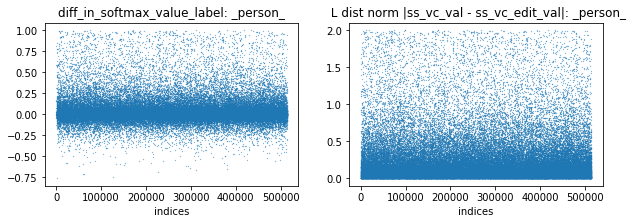

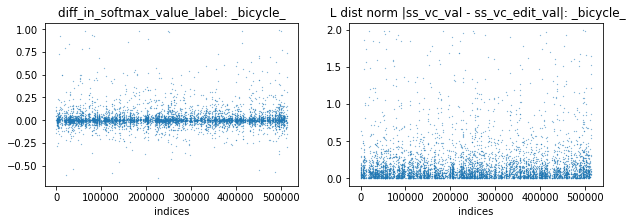

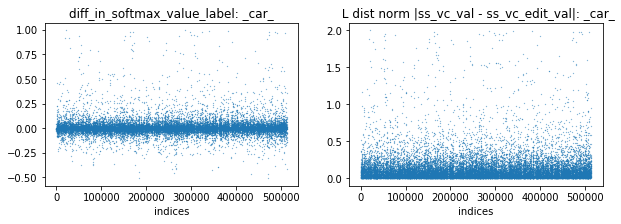

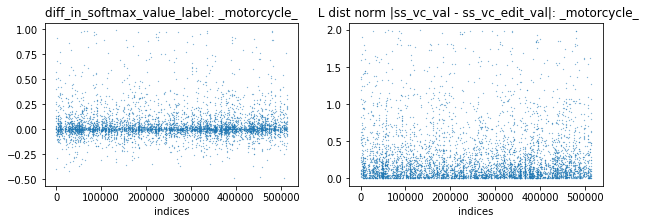

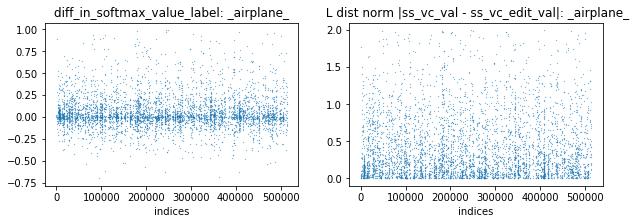

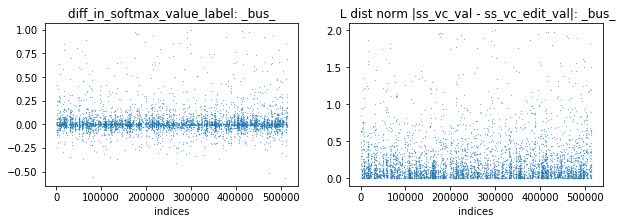

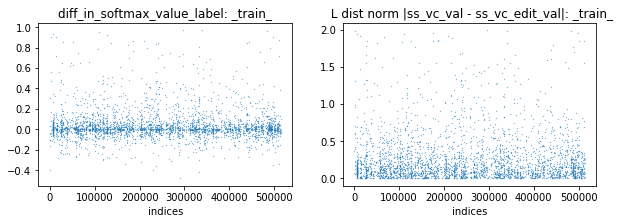

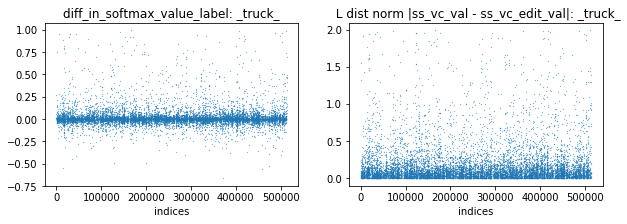

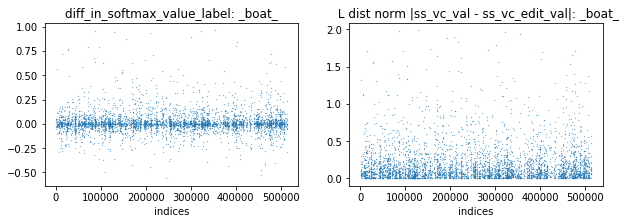

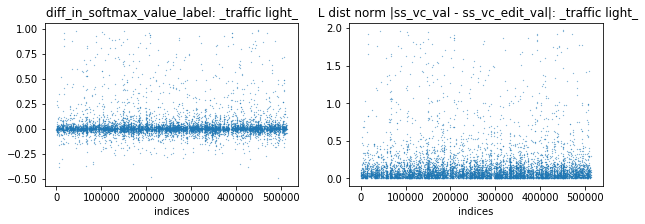

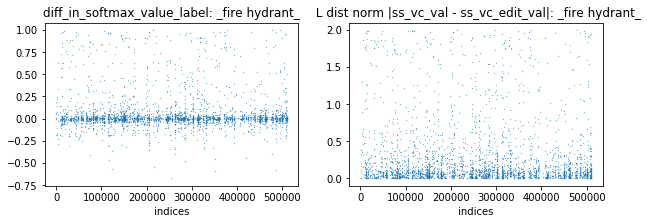

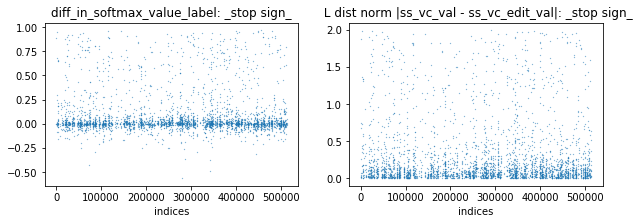

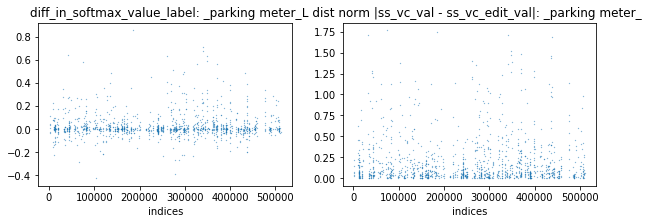

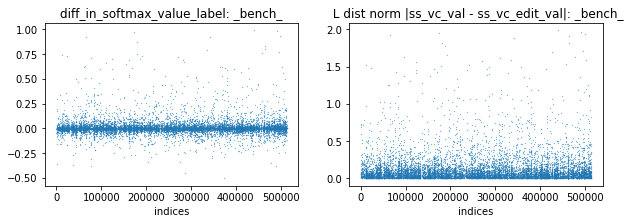

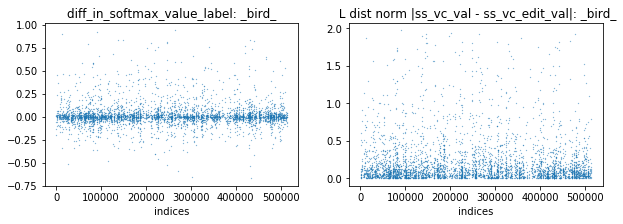

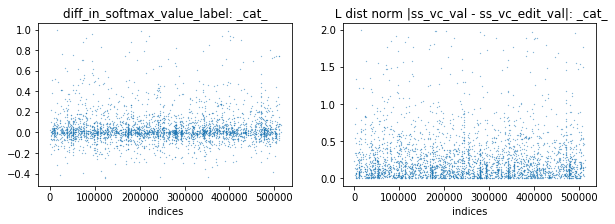

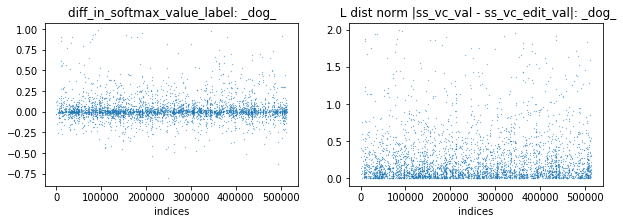

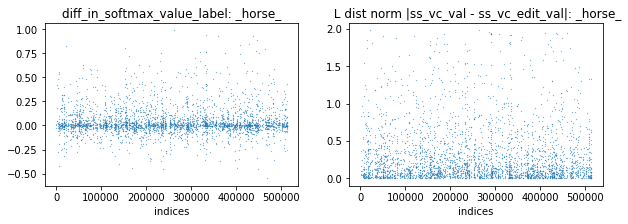

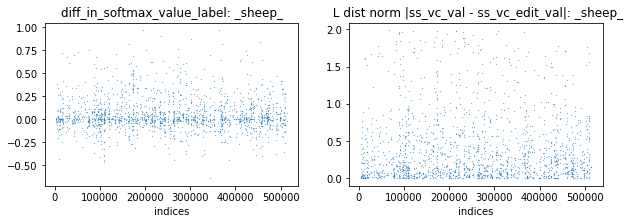

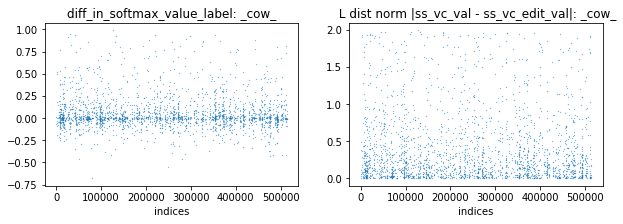

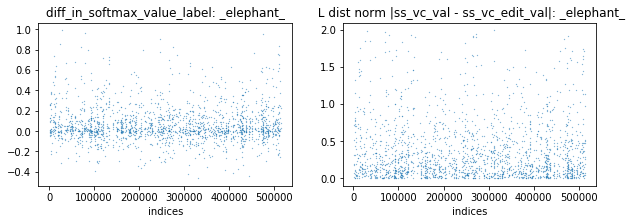

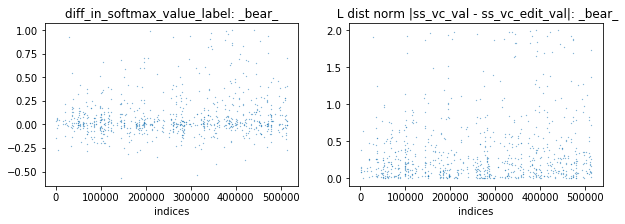

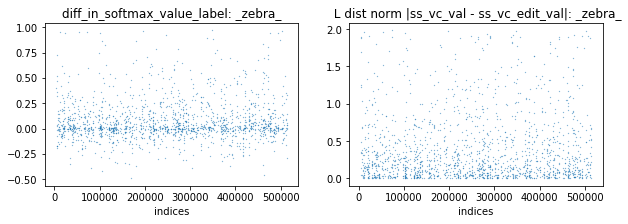

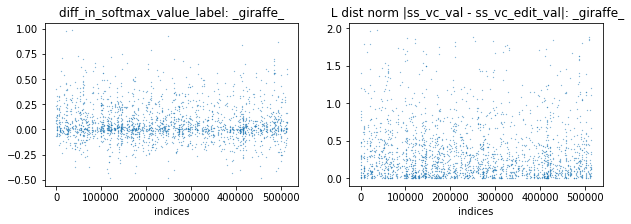

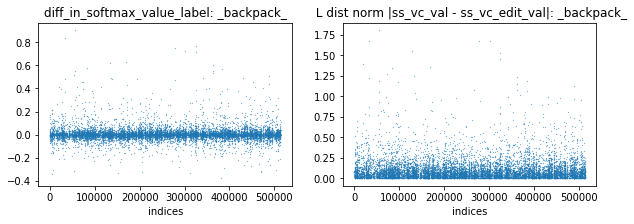

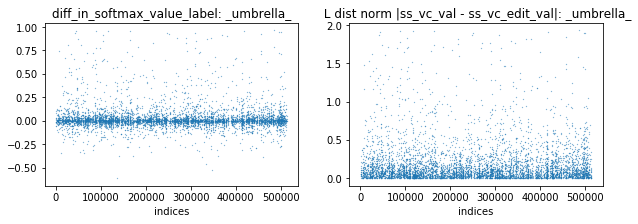

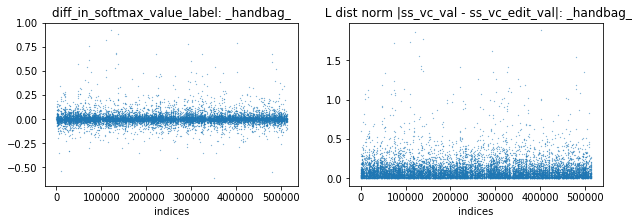

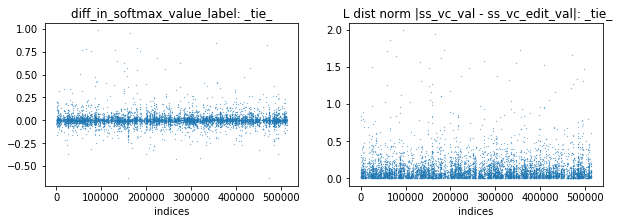

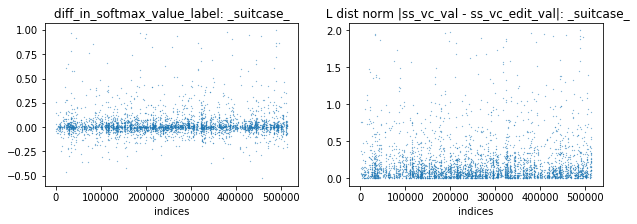

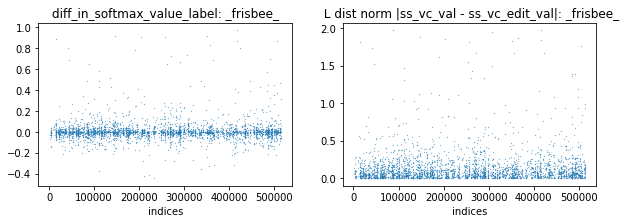

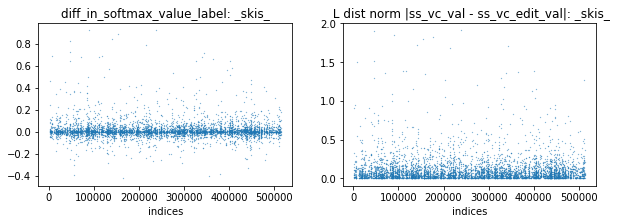

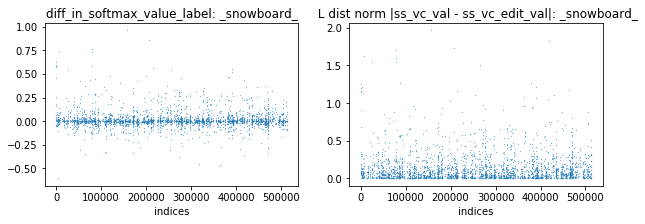

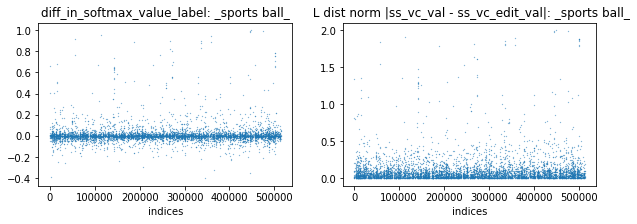

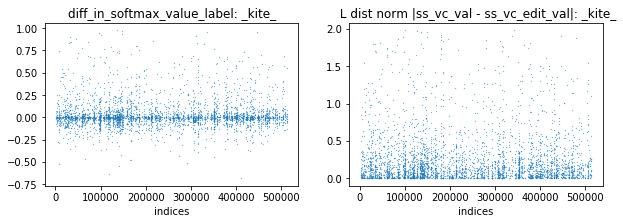

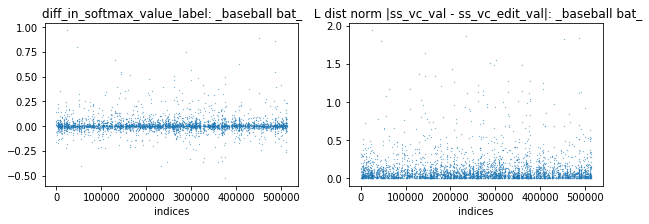

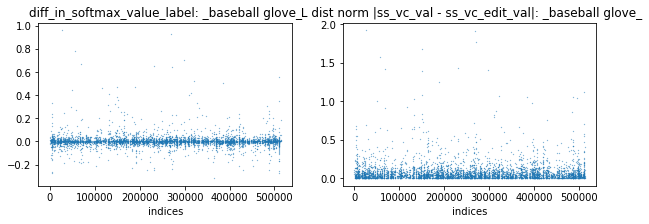

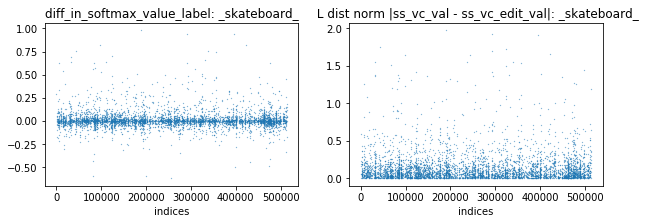

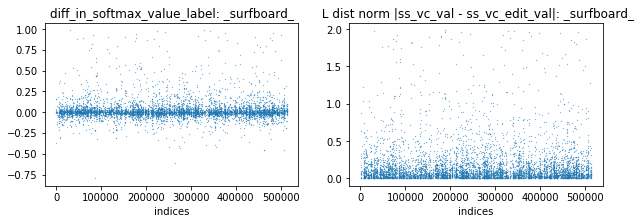

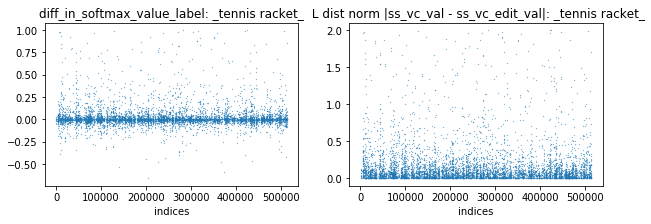

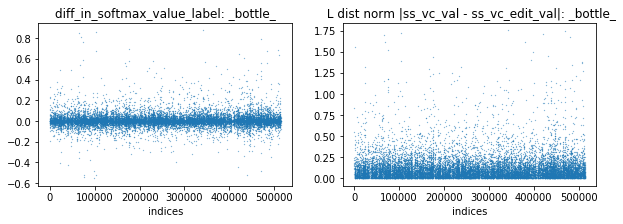

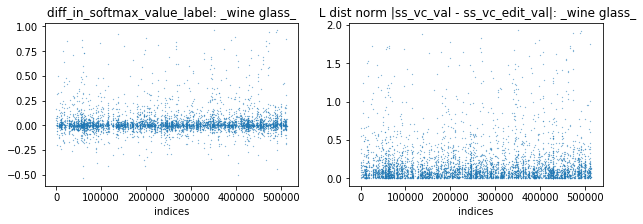

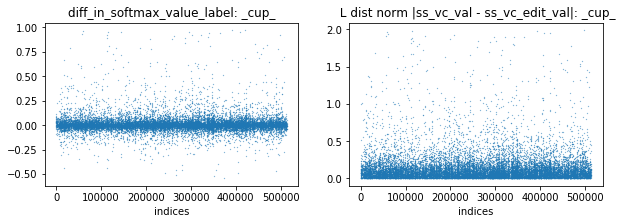

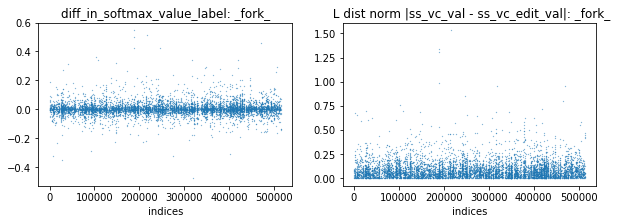

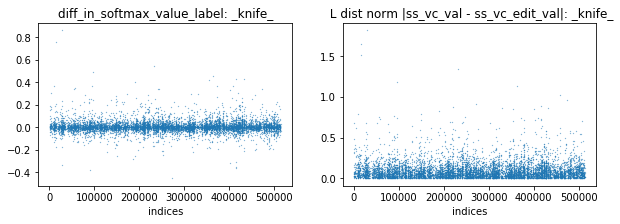

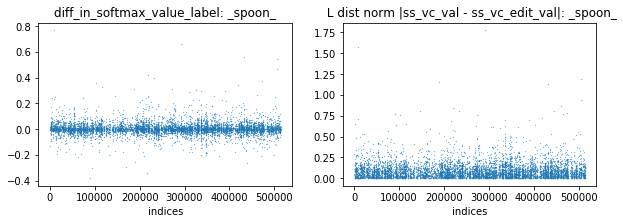

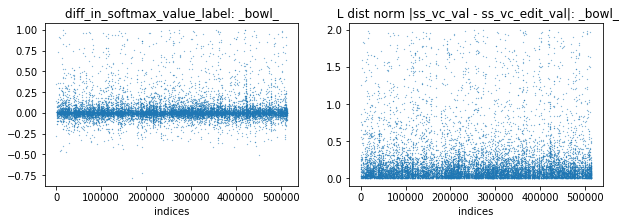

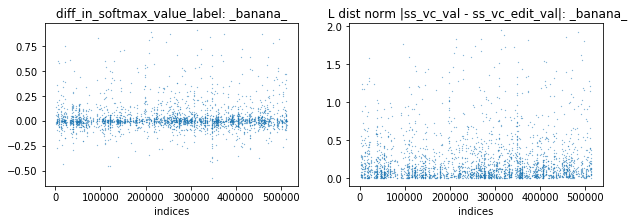

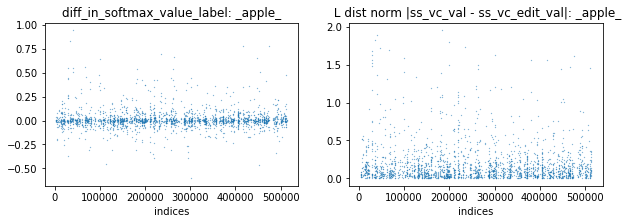

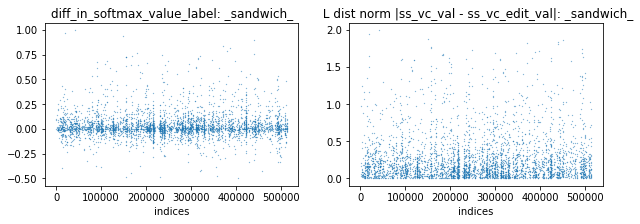

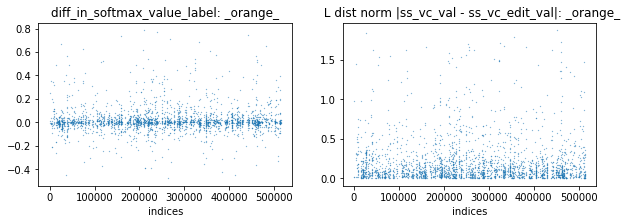

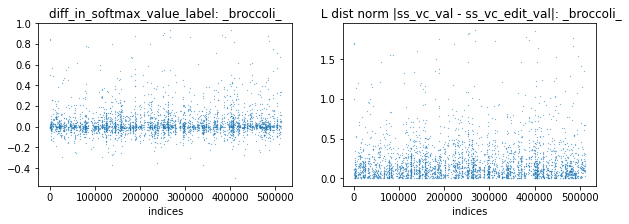

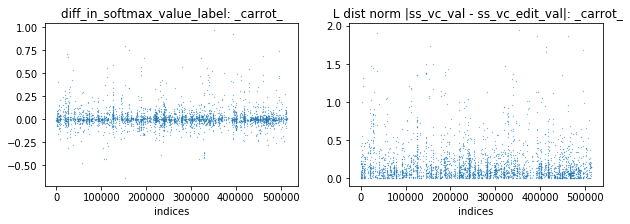

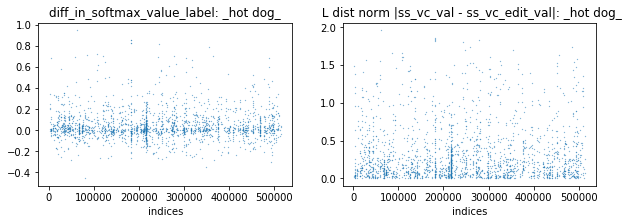

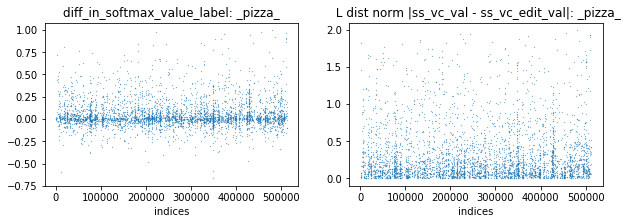

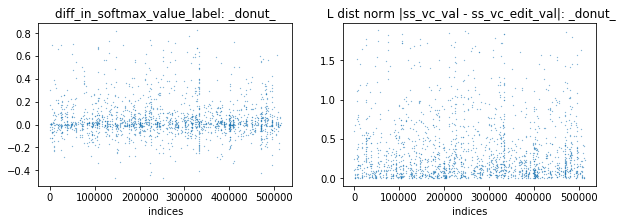

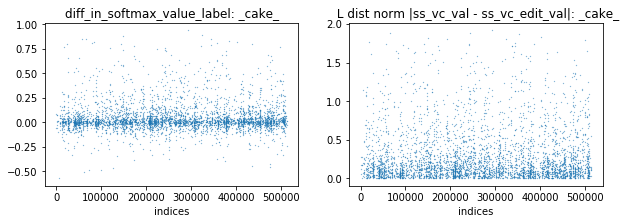

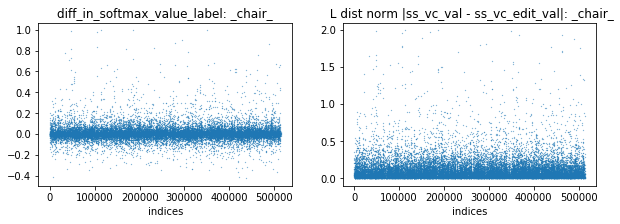

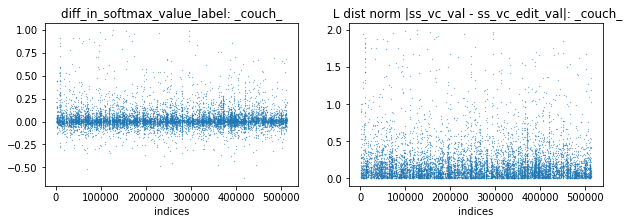

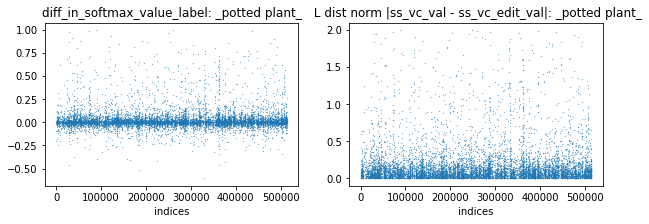

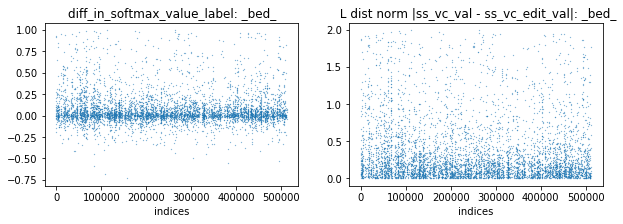

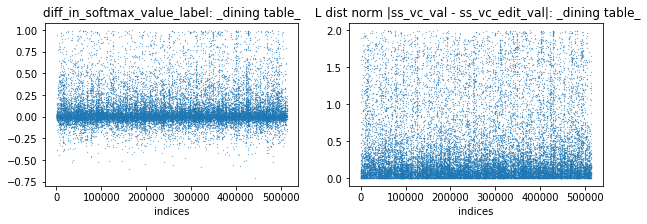

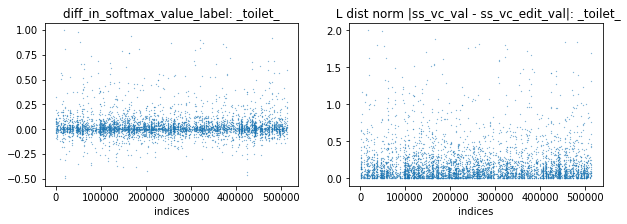

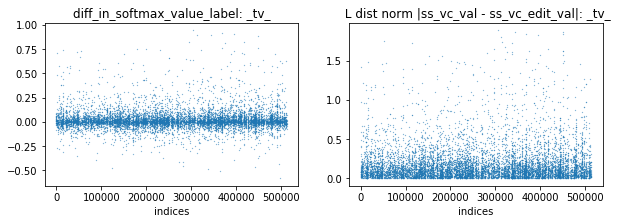

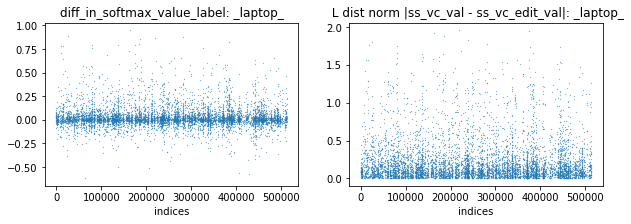

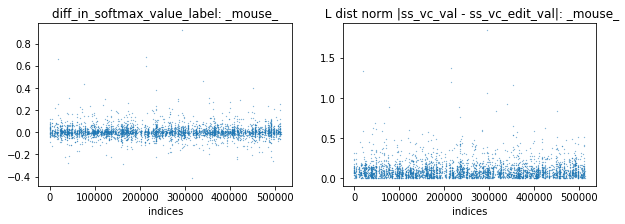

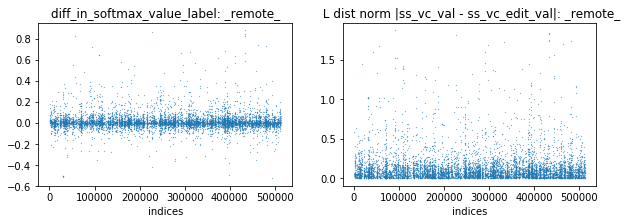

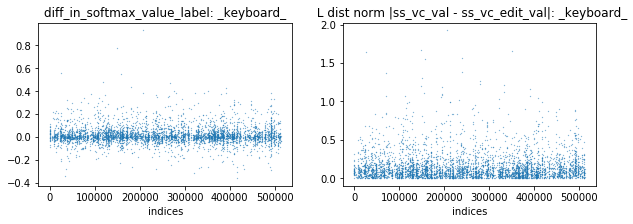

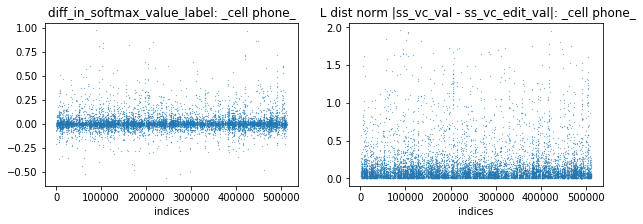

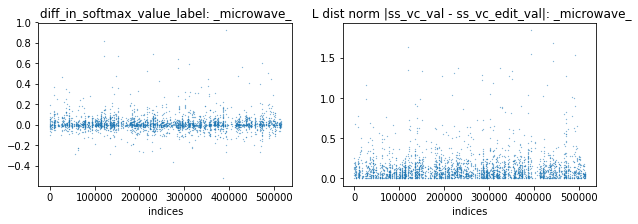

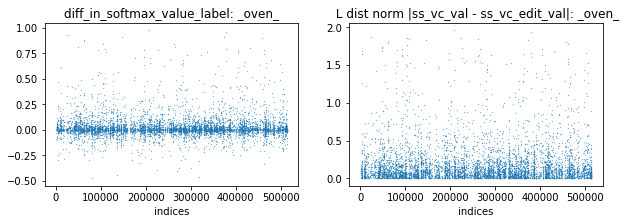

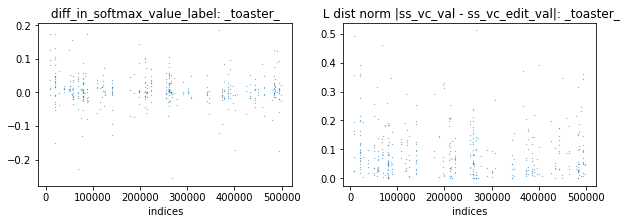

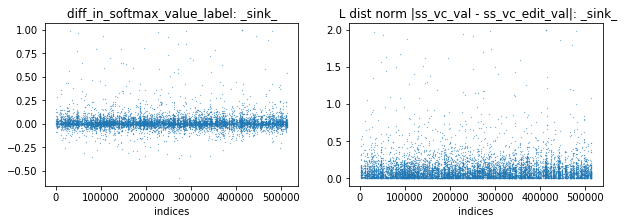

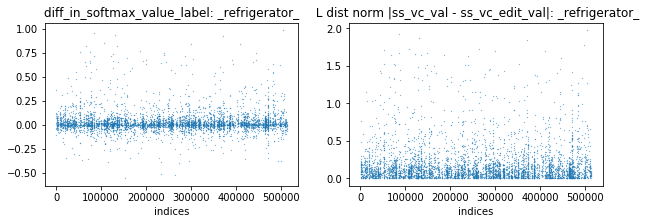

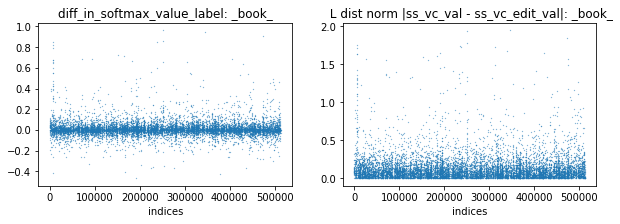

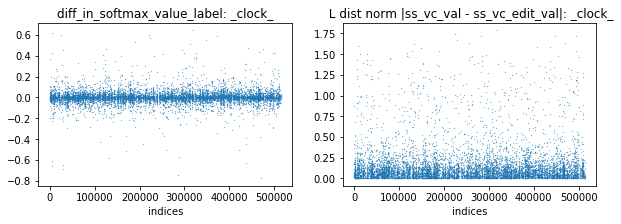

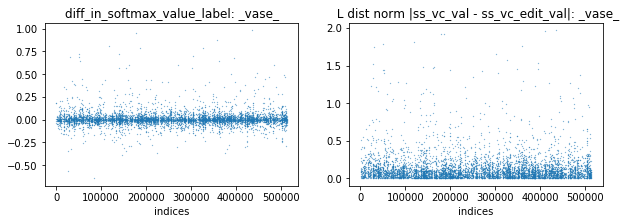

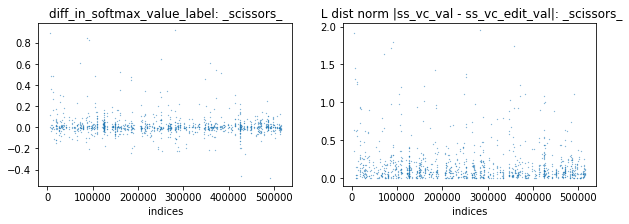

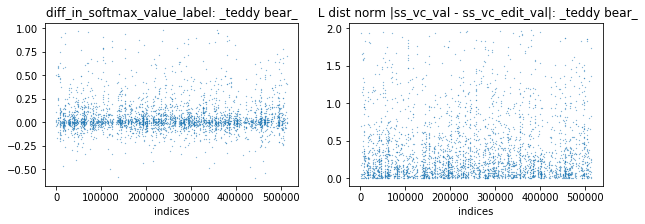

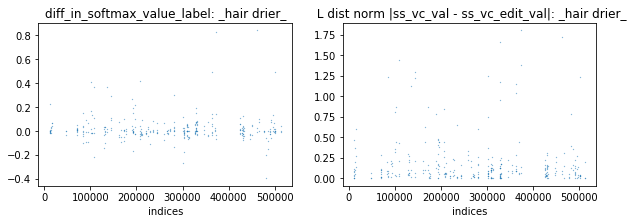

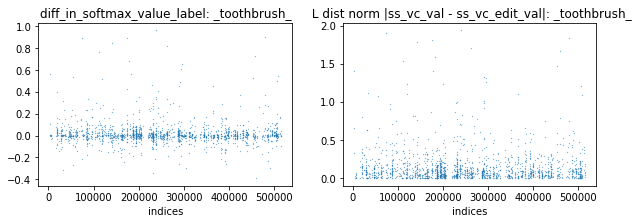

In [14]:
##PLOTTING diff_in softmax and l_dist_norm side by side- in case you notice any pattern!
for i in coco_dict_inv.keys():
    #print('object removed:', i)
    chosen_indices, chosen_diff_list_norm, chosen_diff_list_value, plt_title_suffix = get_indices_diff_list_suffix(
        coco_dict_inv,img_ids_edit_val, ques_type_edit_val, ans_type_edit_val, L_norm_diff, diff_ss_val_label, CLASS=i)

    f = plt.figure(figsize=(10,3))  ##(8,2.5)
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.set_title('diff_in_softmax_value_label: {}'.format(plt_title_suffix))
    ax.scatter(chosen_indices, chosen_diff_list_value, cmap=plt.cm.gist_ncar, s=0.05)
    ax.set_xlabel('indices')

    ax2.set_title(' L dist norm |ss_vc_val - ss_vc_edit_val|: {}'.format(plt_title_suffix))
    ax2.scatter(chosen_indices, chosen_diff_list_norm, cmap=plt.cm.gist_ncar, s=0.05)
    ax2.set_xlabel('indices')
    
    sample_dir = './exp_vqa/interesting_findings/' + str(plt_title_suffix) +'/'
    os.makedirs(sample_dir, exist_ok=True)


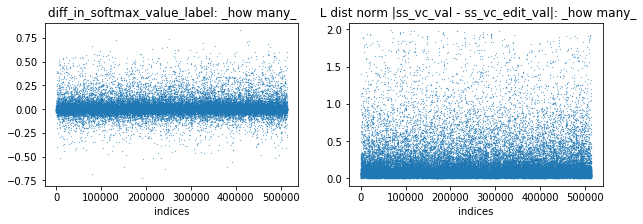

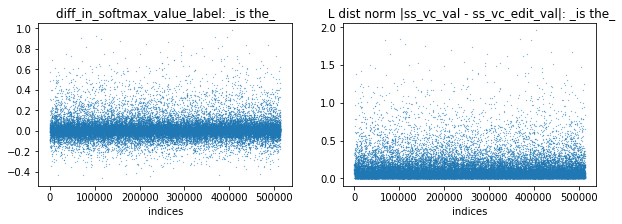

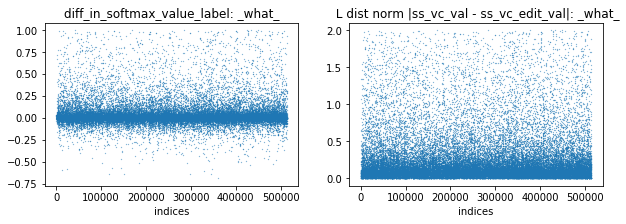

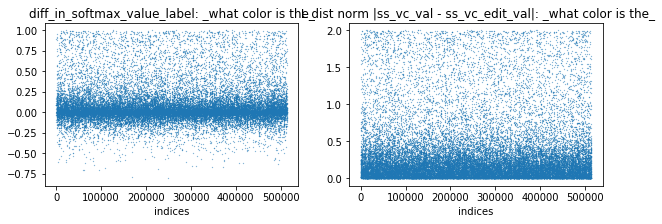

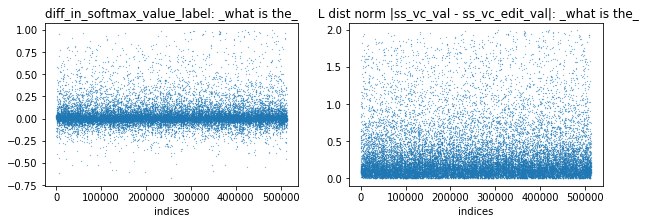

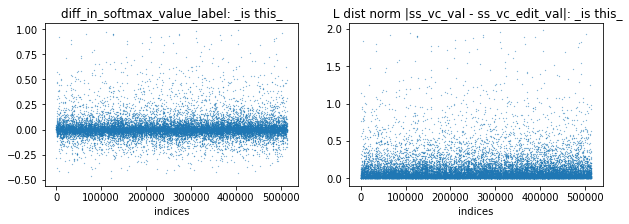

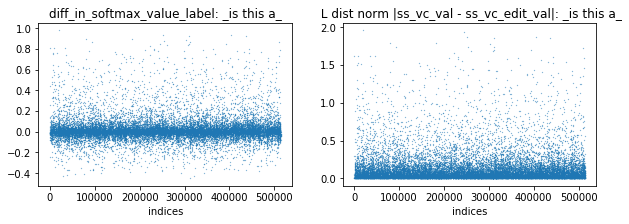

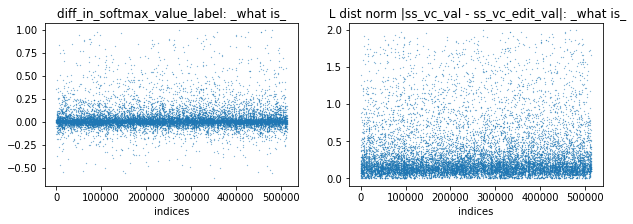

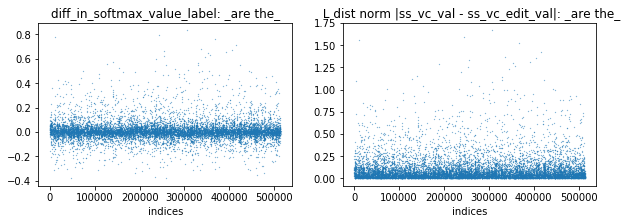

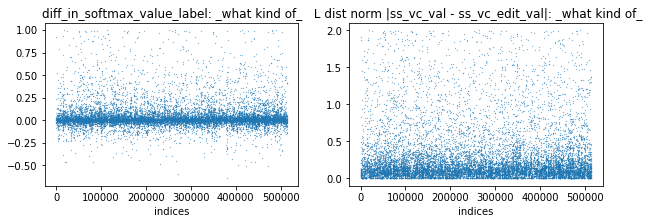

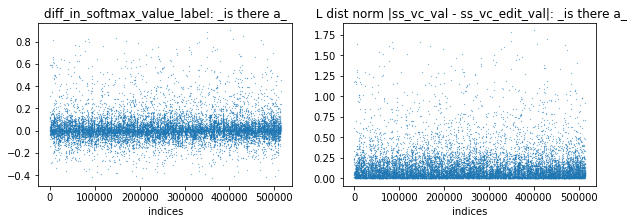

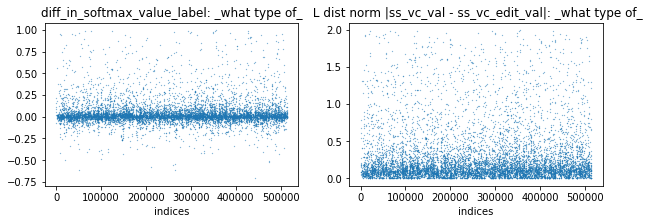

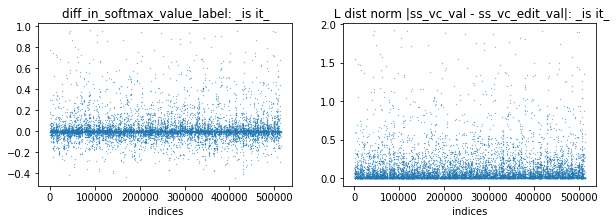

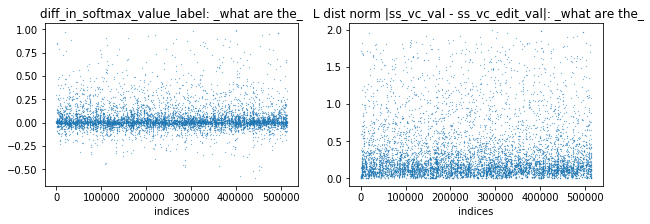

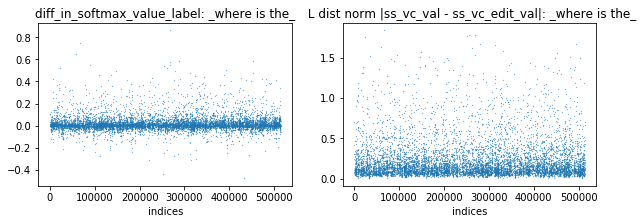

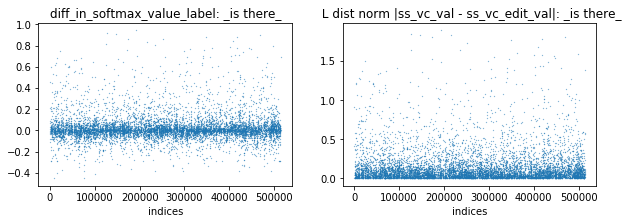

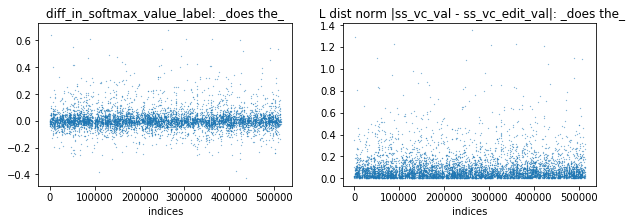

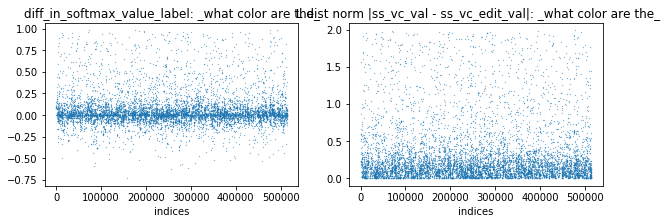

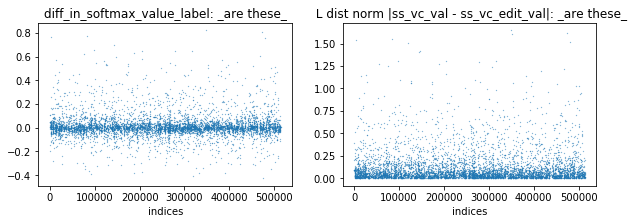

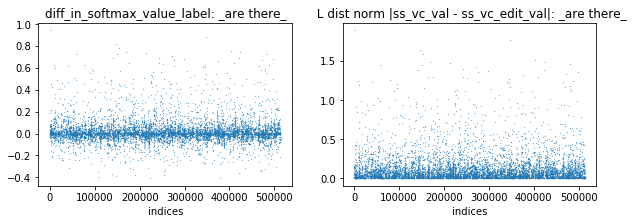

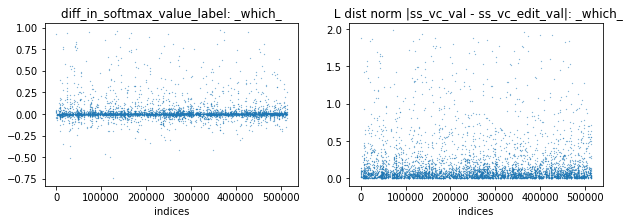

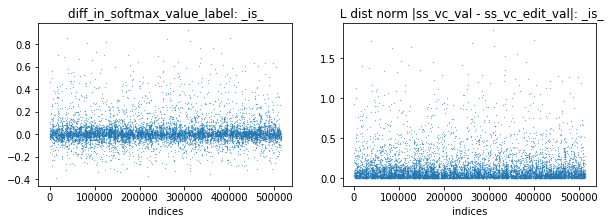

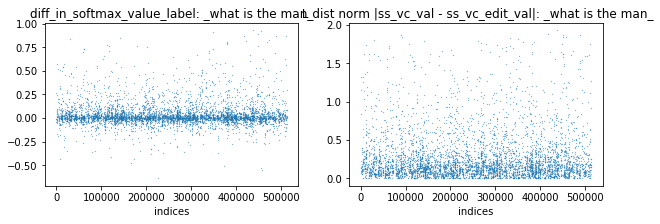

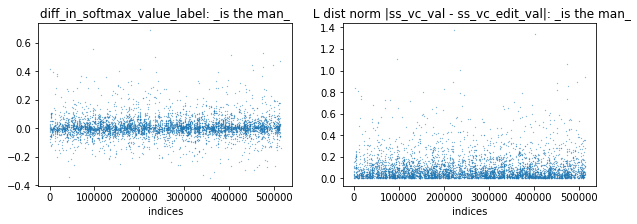

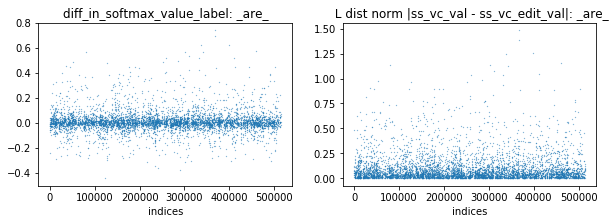

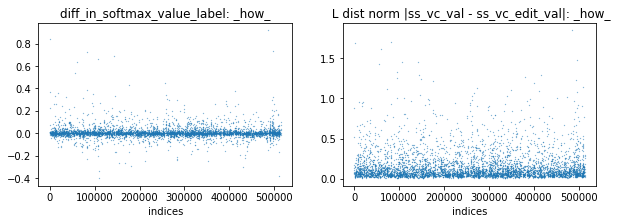

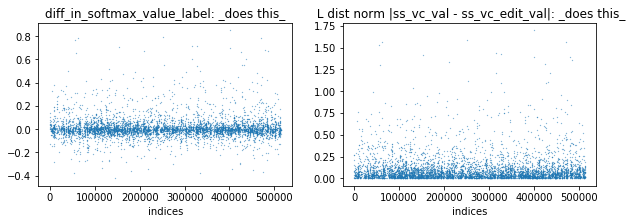

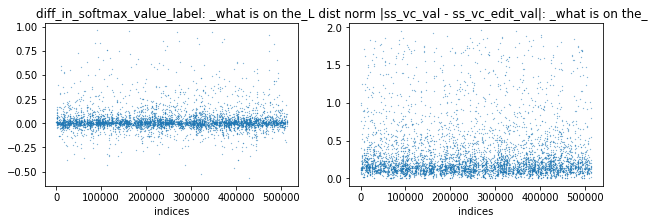

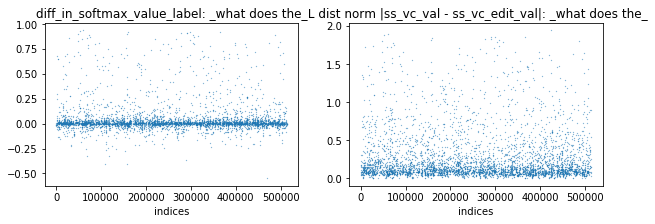

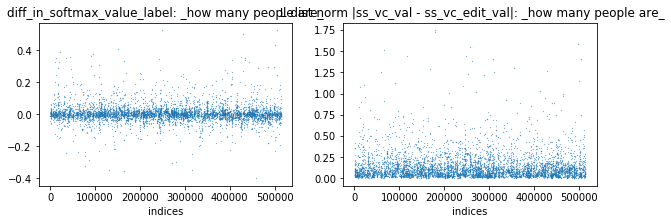

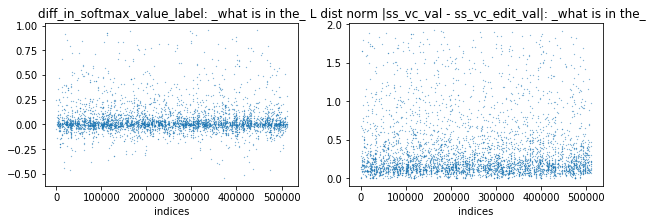

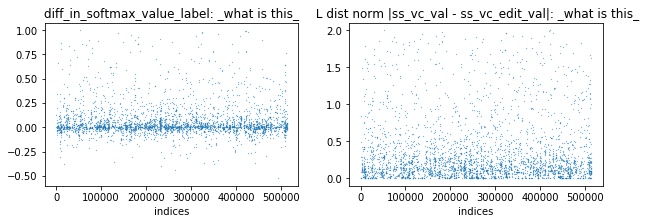

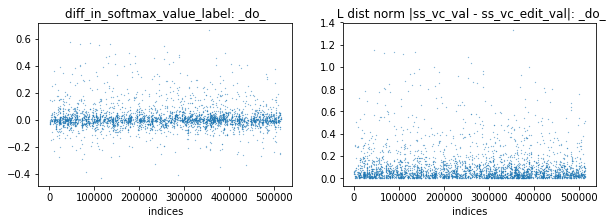

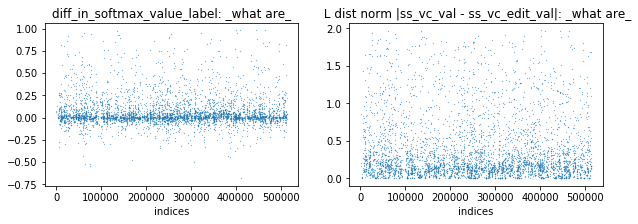

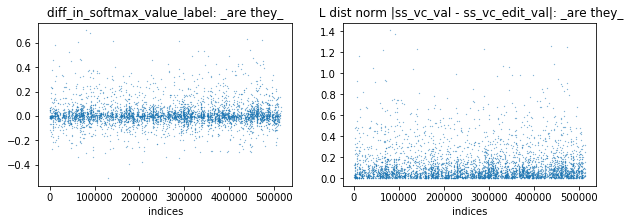

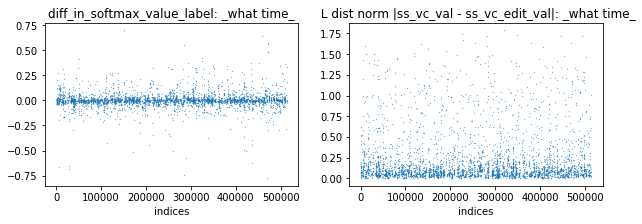

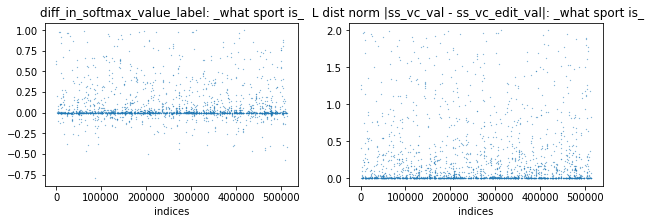

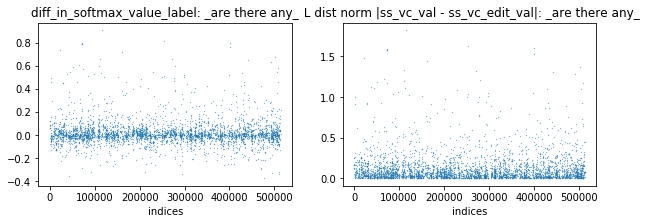

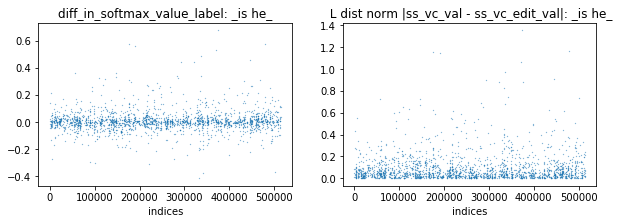

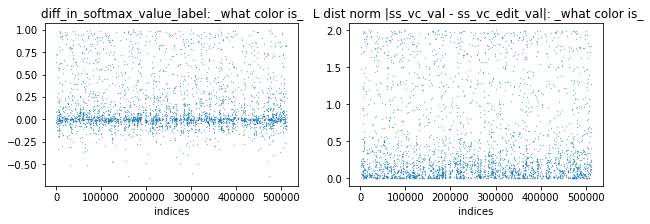

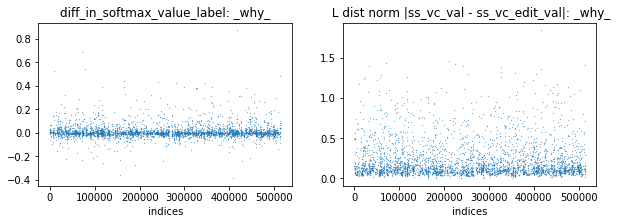

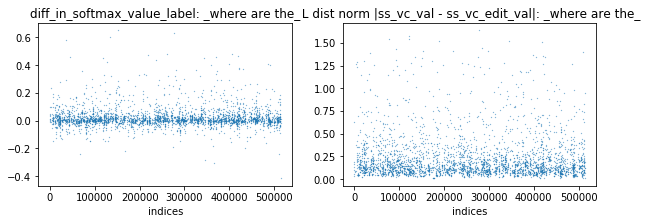

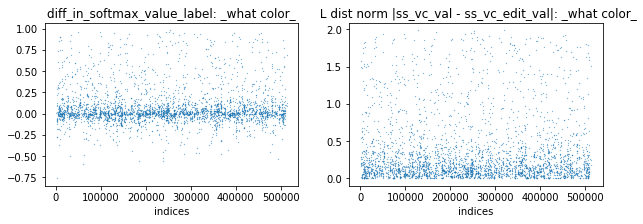

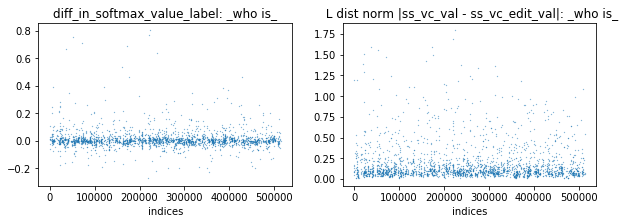

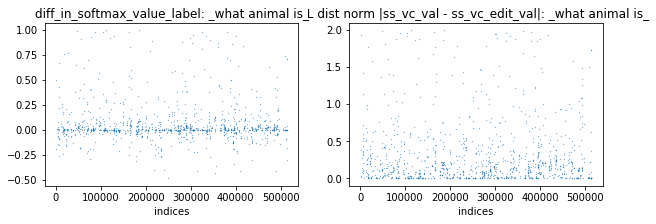

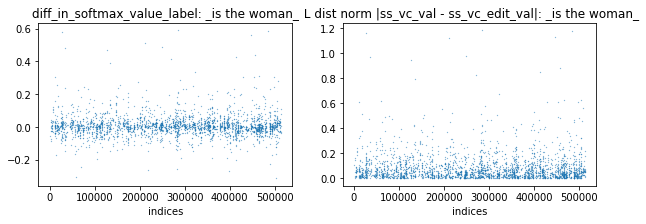

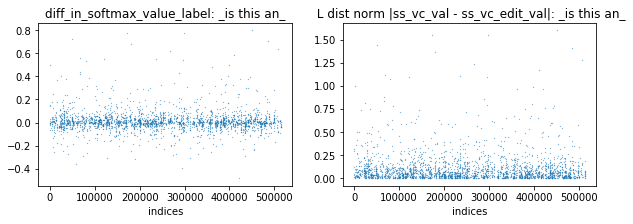

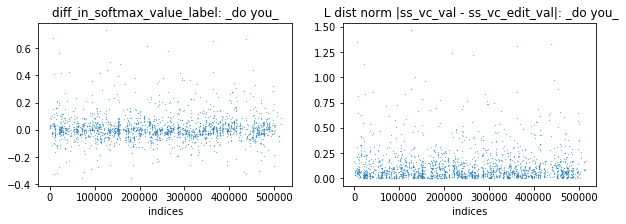

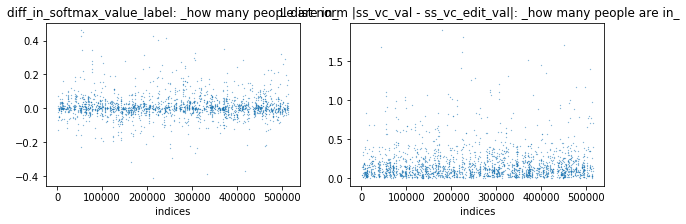

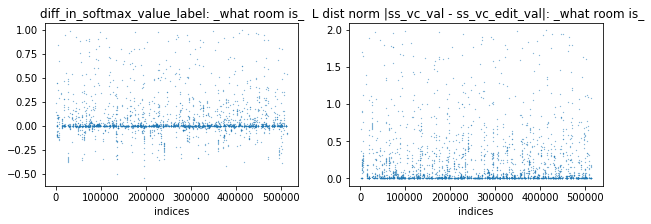

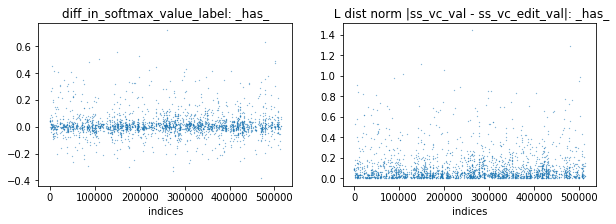

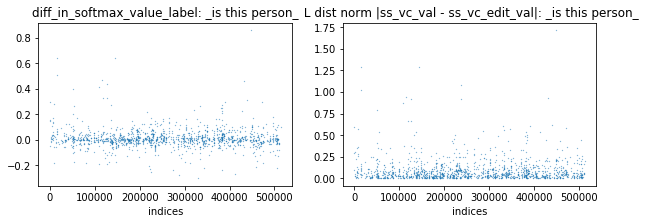

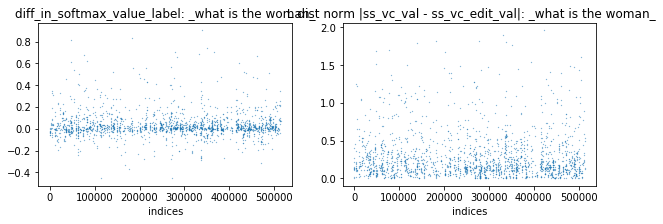

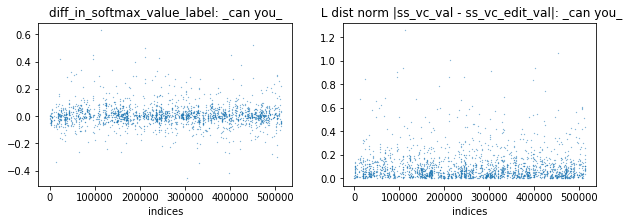

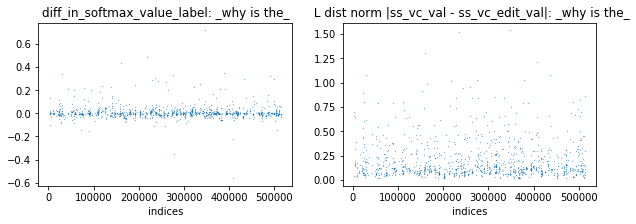

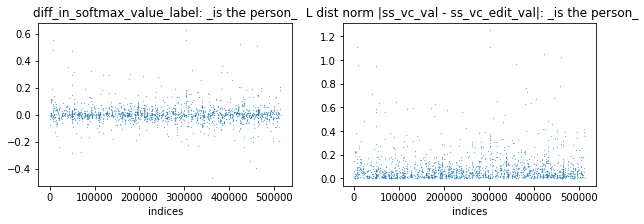

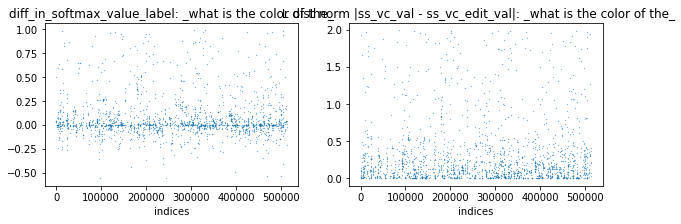

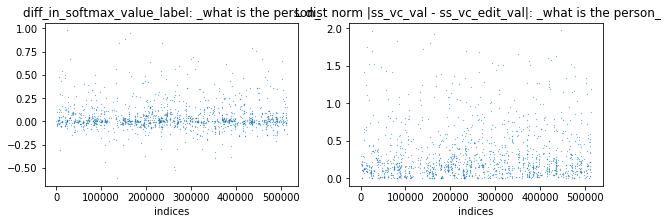

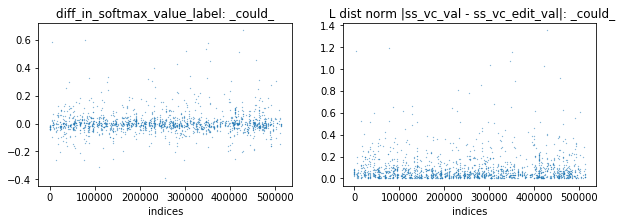

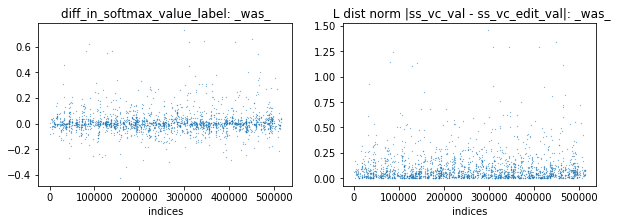

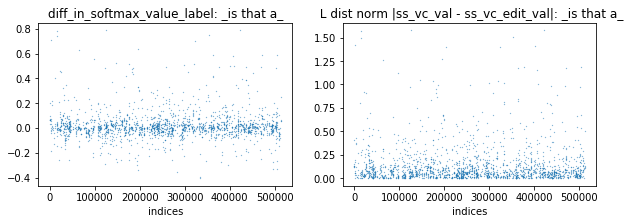

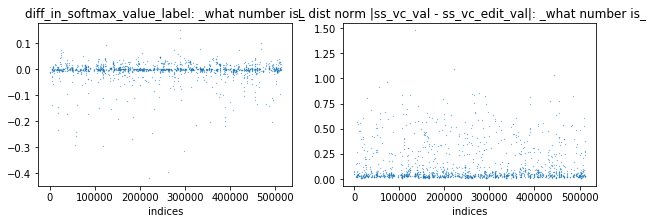

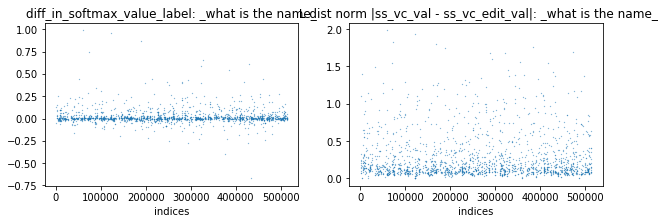

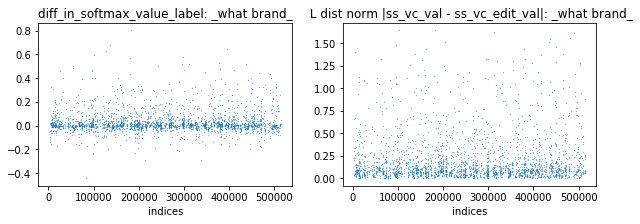

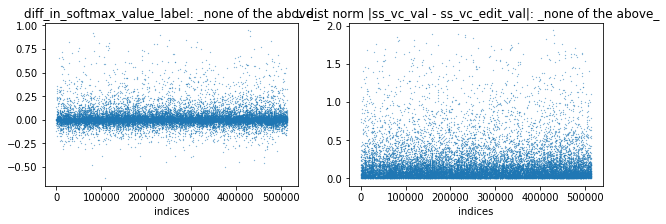

In [15]:
for i in ques_type_off:
    ### creating directories for saving interesting results
    #print('ques_type:', i)

    chosen_indices, chosen_diff_list_norm, chosen_diff_list_value, plt_title_suffix = get_indices_diff_list_suffix(
        coco_dict_inv,img_ids_edit_val, ques_type_edit_val, ans_type_edit_val, L_norm_diff, diff_ss_val_label, QUES_TYPE=i)

    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.set_title('diff_in_softmax_value_label: {}'.format(plt_title_suffix))
    ax.scatter(chosen_indices, chosen_diff_list_value, cmap=plt.cm.gist_ncar, s=0.05)
    ax.set_xlabel('indices')

    ax2.set_title(' L dist norm |ss_vc_val - ss_vc_edit_val|: {}'.format(plt_title_suffix))
    ax2.scatter(chosen_indices, chosen_diff_list_norm, cmap=plt.cm.gist_ncar, s=0.05)
    ax2.set_xlabel('indices')

        
    sample_dir = './exp_vqa/interesting_findings/' + str(plt_title_suffix) +'/'
    os.makedirs(sample_dir, exist_ok=True)


In [5]:
chosen_indices, chosen_diff_list_norm, chosen_diff_list_label, plt_title_suffix = get_indices_diff_list_suffix(
        coco_dict_inv, img_ids_edit_val, ques_type_edit_val, ans_type_edit_val, L_norm_diff , diff_ss_val_label, CLASS='airplane')

In [6]:
len_c = len(chosen_indices)

## one match answer is good
accuracy_ind_before_extended = [i for i in chosen_indices if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i]]
accuracy_ind_after = [i for i in chosen_indices if ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
print('accuracy before editing_extended', round_percent(len(accuracy_ind_before_extended) / len_c), len(accuracy_ind_before_extended))
print('accuracy after editing, one answer match is good', round_percent(len(accuracy_ind_after) / len_c), len(accuracy_ind_after))

##official_way
all_ans_chosen_indices = [all_ans_edit_val[i] for i in chosen_indices]
pred_ans_val_chosen_indices = [extended_pred_ans_val[i] for i in chosen_indices]   
pred_ans_edit_val_chosen_indices = [pred_ans_edit_val[i] for i in chosen_indices]
off_score_val_extended = vqa_score_list(all_ans_chosen_indices, pred_ans_val_chosen_indices, ans_vocab_list)
off_score_edit_val = vqa_score_list(all_ans_chosen_indices, pred_ans_edit_val_chosen_indices, ans_vocab_list)
print('official accuracy before editing_ extended', round_percent(np.sum(off_score_val_extended) / len_c))
print('official accuracy after editing', round_percent(np.sum(off_score_edit_val) / len_c))

##authors way
author_val_extended_acc = np.sum([extended_pred_ans_val[i] == gt_ans_used_edit_val[i] for i in chosen_indices]) / len_c
author_edit_val_acc = np.sum([pred_ans_edit_val[i] == gt_ans_used_edit_val[i] for i in chosen_indices]) / len_c
print('authors accuracy before editing_extended', round_percent(author_val_extended_acc))
print('authors accuracy after editing', round_percent(author_edit_val_acc))

labels_flipped_count = np.sum([extended_pred_ans_val[i] != pred_ans_edit_val[i] for i in chosen_indices]) ##==len(lab_fl_indices)
labels_remained_same_count= np.sum([extended_pred_ans_val[i] == pred_ans_edit_val[i] for i in chosen_indices])
assert(labels_flipped_count+ labels_remained_same_count == len_c)
print('#labels flipped=', labels_flipped_count, '#labels remained same=', labels_remained_same_count)
print('#labels flipped %=',round_percent(labels_flipped_count/ len_c), '#labels remained same %=', round_percent(labels_remained_same_count/ len_c))


lab_fl_ind = [i for i in chosen_indices if extended_pred_ans_val[i] != pred_ans_edit_val[i]]
# label i.e ans was wrong before- right now- one match to 10gt ans is okay
lab_fl_pos = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] not in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
# label i.e ans was right before- now wrong - one match to 10gt ans is okay
lab_fl_neg = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]
lab_fl_right = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
lab_fl_wrong = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] not in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]
print('#labels flipped that show a positive change', len(lab_fl_pos), '         ', round_percent(len(lab_fl_pos) / len(lab_fl_ind)), '%')
print('#labels flipped that show a negative change', len(lab_fl_neg), '         ', round_percent(len(lab_fl_neg) / len(lab_fl_ind)), '%')
print('#labels flipped that are both right', len(lab_fl_right), '         ', round_percent(len(lab_fl_right) / len(lab_fl_ind)), '%')
print('#labels flipped that are both wrong', len(lab_fl_wrong), '         ', round_percent(len(lab_fl_wrong) / len(lab_fl_ind)), '%')
assert(len(lab_fl_pos) + len(lab_fl_neg) + len(lab_fl_right) + len(lab_fl_wrong) == len(lab_fl_ind))

lab_sm_ind = [i for i in chosen_indices if extended_pred_ans_val[i] == pred_ans_edit_val[i]]
# labels that remained exactly same- so two cases possible- either right/wrong
lab_sm_right = [i for i in lab_sm_ind if ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
lab_sm_wrong = [i for i in lab_sm_ind if ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]
print('#labels same that are both right', len(lab_sm_right), '         ', round_percent(len(lab_sm_right) / len(lab_sm_ind)), '%')
print('#labels same that are both wrong', len(lab_sm_wrong), '         ', round_percent(len(lab_sm_wrong) / len(lab_sm_ind)), '%')
assert (len(lab_sm_right) + len(lab_sm_wrong) == len(lab_sm_ind))


accuracy before editing_extended 66.233 2956
accuracy after editing, one answer match is good 61.931 2764
official accuracy before editing_ extended 58.548
official accuracy after editing 54.605
authors accuracy before editing_extended 44.342
authors accuracy after editing 41.609
#labels flipped= 1287 #labels remained same= 3176
#labels flipped %= 28.837 #labels remained same %= 71.163
#labels flipped that show a positive change 184           14.297 %
#labels flipped that show a negative change 376           29.215 %
#labels flipped that are both right 279           21.678 %
#labels flipped that are both wrong 448           34.81 %
#labels same that are both right 2301           72.45 %
#labels same that are both wrong 875           27.55 %


In [86]:
print(plt.rcParams.get('figure.figsize'))
default_figsize_x = plt.rcParams.get('figure.figsize')[0]
default_figsize_y = plt.rcParams.get('figure.figsize')[1]

[6.0, 4.0]


In [100]:
import matplotlib.patches as mpatches


In [108]:
    color_vector = np.zeros(len_edit_val).tolist()
    for i in lab_fl_pos:
        color_vector[i] = 'g'         # green
    for i in lab_fl_neg:
        color_vector[i] = 'r'          # red
    for i in lab_fl_wrong:
        color_vector[i] = 'k'           # black
    for i in lab_fl_right:
        color_vector[i] = 'c'         # yellow
    for i in lab_sm_right:
        color_vector[i] = 'm'          # magenta
    for i in lab_sm_wrong:
        color_vector[i] = 'b'           # blue

    chosen_color_vector = [color_vector[i] for i in chosen_indices]

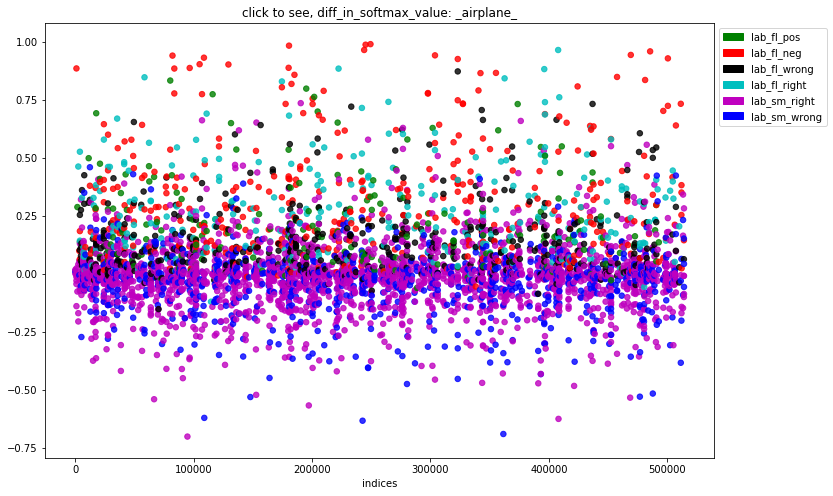

In [114]:
default_figsize_x = plt.rcParams.get('figure.figsize')[0]
default_figsize_y = plt.rcParams.get('figure.figsize')[1]
fig = plt.figure(figsize=(2*default_figsize_x,2*default_figsize_y));
#fig = plt.figure(figsize=(12,8))
ax = plt.subplot();
# ax.set_title('click to see; |ss_vc_val - ss_vc_edit_val|')
ax.set_title('click to see, diff_in_softmax_value: {}'.format(plt_title_suffix))
#L_norm_diff, diff_ss_val_label
ax.scatter(chosen_indices, chosen_diff_list_label, alpha=0.8,c= chosen_color_vector,s=30)
#ax.legend(bbox_to_anchor=(1.0, 1.0))  # (1.1, 1.05))
patch1 = mpatches.Patch(color='g', label='lab_fl_pos')
patch2 = mpatches.Patch(color='r', label='lab_fl_neg')
patch3 = mpatches.Patch(color='k', label='lab_fl_wrong')
patch4 = mpatches.Patch(color='c', label='lab_fl_right')
patch5 = mpatches.Patch(color='m', label='lab_sm_right')
patch6 = mpatches.Patch(color='b', label='lab_sm_wrong')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6],bbox_to_anchor=(1.0, 1.0) )
plt.xlabel('indices')
plt.show()


In [ ]:
#     lab_fl_ind = [i for i in chosen_indices if extended_pred_ans_val[i] != pred_ans_edit_val[i]]
#     # label i.e ans was wrong before- right now- one match to 10gt ans is okay
#     lab_fl_pos = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] not in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
#     # label i.e ans was right before- now wrong - one match to 10gt ans is okay
#     lab_fl_neg = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]
#     lab_fl_right = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] in all_ans_edit_val[i]]
#     lab_fl_wrong = [i for i in lab_fl_ind if ans_vocab_list[extended_pred_ans_val[i]] not in all_ans_edit_val[i] and ans_vocab_list[pred_ans_edit_val[i]] not in all_ans_edit_val[i]]

In [117]:
all_ans_edit_val1 = ['red, white', 'red, white, and blue', 'red white blue', 'red white and blue', 'red/blue', 'blue and red', 'red, white, blue', 'red and blue', 'red, white, blue', 'red and blue']
extended_pred_ans_val1 = 'red'
pred_ans_edit_val1 = 'white'


In [124]:
'white' in all_ans_edit_val1

False